## Competition between transcription factor binding sites

Required packages:

In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

fdir = '../data/'
out_fdir = '../plots/fig9/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb` (where we explain the code for generating synthetic datasets for the six common regulatory architectures), we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Changing the number of repressor binding sites

As usual, we first specify the parameters needed to build the thermodynamic model for a simple repression promoter and the range of values for repressor binding site copy number.

In [6]:
ep_wt, er_wt = -5, -15
P = 5000
R = 10
l_M = np.arange(1, 200, 5)
N = len(genome)

For each repressor copy number, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [7]:
num_mutants = 20
mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

Based on these mutant libraries, we simulate synthetic datasets for each value in `l_M`, note that here we are using the chemical potential-based thermodynamic model for the simple repression promoter. We keep track of the average mutual information at the repressor binding site and store it in `signal_rep`.

In [8]:
signal_rep = []

for M in l_M:
    rep = []
    for i in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                            *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0],
                            preset_mutants=mutant_bank[i])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    signal_rep.append(np.mean(rep))

We plot the average mutual information against the copy number of binding sites, normalized by the copy number of repressors in the system

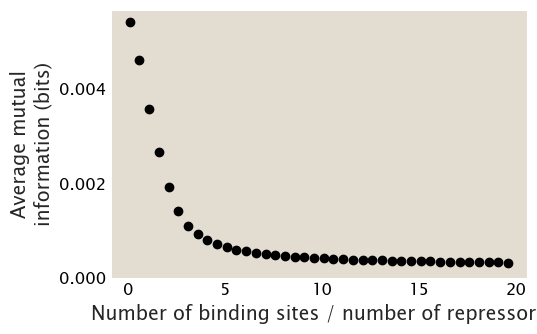

In [9]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.scatter(l_M/10, signal_rep, color='k')
ax.set_xlabel('Number of binding sites / number of repressors', fontsize=14)
ax.set_ylabel('Average mutual\ninformation (bits)', fontsize=14)
ax.set_yticks([0, 0.002, 0.004])
plt.tight_layout()
plt.subplots_adjust(right=1.07)
plt.savefig(out_fdir + 'chemical_potential.pdf', bbox_inches='tight')

### 1.2 Example footprints with different number of repressor binding sites

Below we plot a representative information footprint where there is only one copy of the repressor binding site.

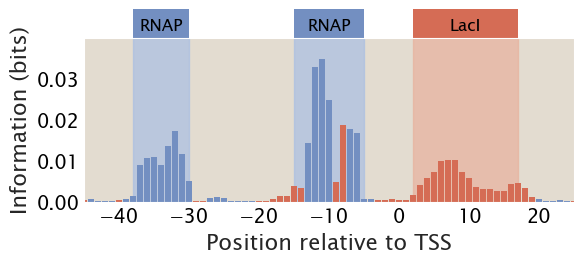

In [10]:
ep_wt, er_wt = -5, -15
P = 5000
R = 10
M = 1
N = len(genome)

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                        *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'chemical_potential_fp1.pdf')

We also plot a representative information footprint where there are 50 copies of the repressor binding site.

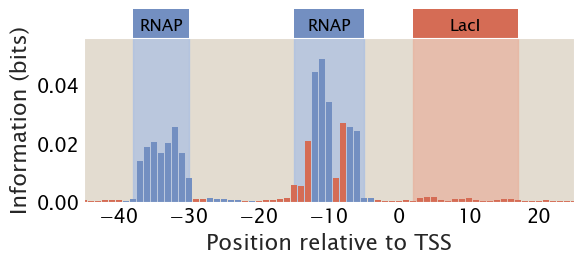

In [11]:
ep_wt, er_wt = -5, -15
P = 5000
R = 10
M = 50
N = len(genome)

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound_cp, [rnap_site, rep_site], 
                        *[rnap_emat, rep_emat, P, R, M, N, ep_wt, er_wt, 0, 0])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'chemical_potential_fp2.pdf')